In [52]:
import networkx as nx
import pandas as pd
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [29]:
def extract_number(filename):
    """extract number from filename"""
    match = re.search(r'(\d+)', filename)
    return int(match.group(1)) if match else float('inf')  # Files without numbers go last

# List and sort files
files = sorted(os.listdir(base_file), key=extract_number)

# for graph in files:
#     filepath = os.path.join(base_file, graph)


In [42]:
base_dir = 'graphs'

# Extract phase numbers and sort numerically
def extract_phase(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group(1)) if match else float('inf')

# Get and sort files graph_1.pickle → graph_51.pickle
graph_files = sorted([f for f in os.listdir(base_dir) if f.startswith("graph_") and f.endswith(".pickle")],
                     key=extract_phase)

# Initialize centrality matrices as dictionaries (phase: {character: score})
degree_matrix = {}
betweenness_matrix = {}
eigenvector_matrix = {}

all_characters = set()

# Load each graph and compute centralities
for file in graph_files[1:]:
    phase = extract_phase(file)  # numeric phase number
    filepath = os.path.join(base_dir, file)
    
    with open(filepath, 'rb') as f:
        G = pickle.load(f)

    # Ensure graph is undirected
    if not isinstance(G, nx.Graph):
        G = nx.Graph(G)

    # Collect all characters in this graph
    nodes = list(G.nodes())
    all_characters.update(nodes)
    
    # Compute centralities
    # Using weights if available
    degree_cent = nx.degree_centrality(G)  # networkx uses normalized degree centrality

    betweenness_cent = nx.betweenness_centrality(G, weight='weight', normalized=True)

    try:
        eigenvector_cent = nx.eigenvector_centrality(G, weight='weight', max_iter=500)
    except nx.PowerIterationFailedConvergence:
        print(f"  Eigenvector centrality did not converge for Phase {phase}. Filling with NaN.")
        eigenvector_cent = {node: np.nan for node in nodes}

    # Store values in phase dictionaries
    degree_matrix[phase] = degree_cent
    betweenness_matrix[phase] = betweenness_cent
    eigenvector_matrix[phase] = eigenvector_cent

# Convert to DataFrames
all_characters = sorted(all_characters)  # consistent row ordering
phases = sorted(degree_matrix.keys())  # sorted phase ordering

def build_matrix(matrix_dict, name):
    df = pd.DataFrame(index=all_characters, columns=phases, dtype=float)
    for phase in phases:
        for char in all_characters:
            df.at[char, phase] = matrix_dict.get(phase, {}).get(char, np.nan)
    df.to_csv(f"{name}_centrality_matrix.csv")
    return df

degree_df = build_matrix(degree_matrix, "degree")
betweenness_df = build_matrix(betweenness_matrix, "betweenness")
eigenvector_df = build_matrix(eigenvector_matrix, "eigenvector")


In [44]:
def raw_cos(a, b):
    # Only consider indices where both a and b are non-null
    common_idx = a.notna() & b.notna()
    
    # Return 0 if no common ratings
    if common_idx.sum() == 0:
        return 0
    
    # Extract the common ratings
    v1 = a[common_idx].values
    v2 = b[common_idx].values
    
    # Compute cosine similarity
    numerator = np.dot(v1, v2)
    denom = np.linalg.norm(v1) * np.linalg.norm(v2)
    
    if denom == 0:
        return 0
    
    return numerator / denom

In [45]:
eigenvector_df.columns

Index([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51],
      dtype='int64')

In [50]:
meta_changes = []
for version in eigenvector_df.columns[:-1]:
    prev_version = eigenvector_df[version]
    curr_version = eigenvector_df[version + 1]
    meta_changes.append(raw_cos(prev_version, curr_version))

In [57]:
range(2, len(meta_changes) + 1)

range(2, 50)

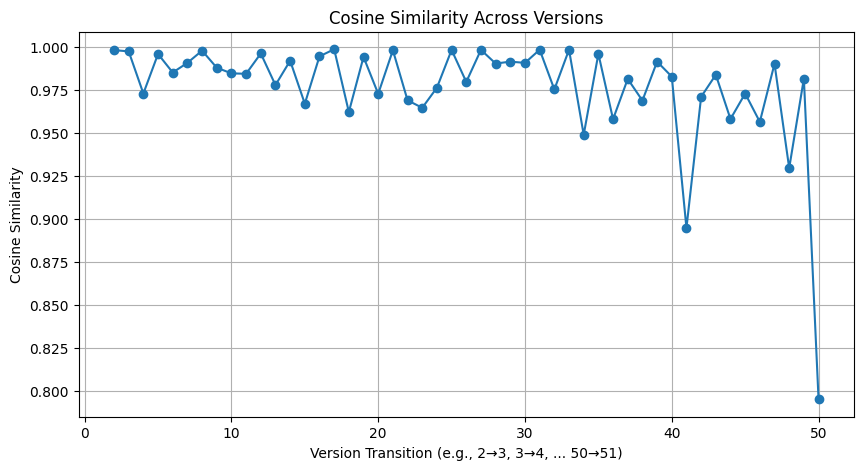

In [61]:
plt.figure(figsize=(10, 5))
plt.plot(range(2, len(meta_changes) + 2), meta_changes, marker='o')
plt.title('Cosine Similarity Across Versions')
plt.xlabel('Version Transition (e.g., 2→3, 3→4, ... 50→51)')
plt.ylabel('Cosine Similarity')
plt.grid(True)
plt.show()


In [55]:
pd.read_csv('abyss_rank_activity.csv')

,Version,Version Name,Total Samples,Effective Samples,Patch
0,51,Version: 6.0(Phase II),123768,97455,6.0
1,50,Version: 6.0(Phase I),101909,77793,6.0
2,49,Version: 5.8(Phase I),142018,120354,5.8
3,48,Version: 5.7(Phase I),122176,94710,5.7
4,47,Version: 5.6(Phase II),101501,82521,5.6
5,46,Version: 5.6(Phase I),135181,115539,5.6
6,45,Version: 5.5(Phase I),122925,100758,5.5
7,44,Version: 5.4(Phase II),133046,115692,5.4
8,43,Version: 5.4(Phase I),141804,125490,5.4
9,42,Version: 5.3(Phase I),145286,113505,5.3
